In [1]:
import torch
import torchvision

print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)



Torch version: 2.6.0+cu126
Torchvision version: 0.21.0+cu126


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import os
import pandas as pd
import numpy as np
import cv2
import heapq
import matplotlib.pyplot as plt
from PIL import Image


In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
data_dir = "C:/Users/choud/OneDrive/Desktop/Code/UAV_research/DataSet"
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "valid")
test_dir = os.path.join(data_dir, "test")

In [6]:
train_annotations = pd.read_csv(os.path.join(train_dir, "_annotations.csv"))
valid_annotations = pd.read_csv(os.path.join(valid_dir, "_annotations.csv"))
test_annotations = pd.read_csv(os.path.join(test_dir, "_annotations.csv"))


In [7]:
train_annotations["class"] -= train_annotations["class"].min()
valid_annotations["class"] -= valid_annotations["class"].min()
test_annotations["class"] -= test_annotations["class"].min()
num_classes = train_annotations["class"].max() + 1

In [8]:
print("Train labels:", train_annotations["class"].unique())
print("Valid labels:", valid_annotations["class"].unique())
print("Test labels:", test_annotations["class"].unique())

Train labels: [0 1]
Valid labels: [0 1]
Test labels: [1 0]


In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [10]:
class UAVDataset(Dataset):
    def __init__(self, annotations, img_dir, transform=None):
        self.annotations = annotations
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label = int(self.annotations.iloc[idx, 3])
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [11]:
train_dataset = UAVDataset(train_annotations, train_dir, transform)
valid_dataset = UAVDataset(valid_annotations, valid_dir, transform)
test_dataset = UAVDataset(test_annotations, test_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [12]:
model = models.mobilenet_v2(pretrained=True)
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(model.last_channel, num_classes)
)
model = model.to(device)

c:\Users\choud\OneDrive\Desktop\Code\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\choud\OneDrive\Desktop\Code\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)


In [14]:
epochs = 150
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        print("Sample labels before moving to CUDA:", labels)
        images, labels = images.to(device), labels.to(device)
        
        # Ensure labels are within valid range
        if labels.max() >= num_classes or labels.min() < 0:
            print("Warning: Invalid label detected! Skipping batch.")
            continue
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_loss = running_loss / len(valid_loader)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Sample labels before moving to CUDA: tensor([0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,
        0, 1, 1, 1, 1, 0, 1, 1])
Sample labels before moving to CUDA: tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
        1, 1, 1, 1, 1, 0, 1, 1])
Sample labels before moving to CUDA: tensor([1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        0, 0, 1, 1, 0, 1, 1, 0])
Sample labels before moving to CUDA: tensor([0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 1])
Sample labels before moving to CUDA: tensor([1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
        1, 0, 1, 1, 1, 1, 1, 1])
Sample labels before moving to CUDA: tensor([1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 0])
Sample labels before moving to CUDA: tensor([0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1

In [15]:
torch.save(model.state_dict(), "mobilenet_uav123_optimized.pth")

In [16]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 100.00%


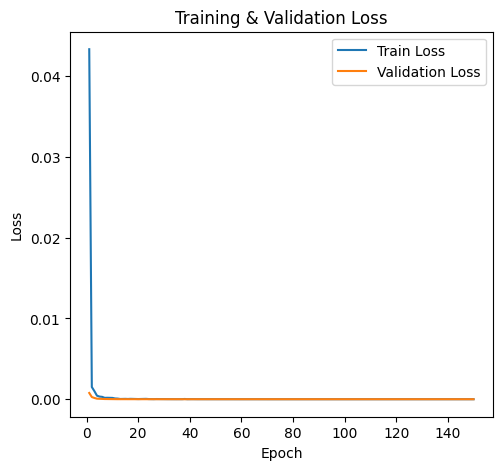

In [17]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()


In [18]:
# A* Pathfinding Algorithm
def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def a_star_search(grid, start, goal):
    rows, cols = len(grid), len(grid[0])
    open_set = [(0, start)]
    came_from = {}
    g_score = {start: 0}
    f_score = {start: heuristic(start, goal)}
    
    while open_set:
        _, current = heapq.heappop(open_set)
        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            return path[::-1]
        
        neighbors = [(current[0] + dx, current[1] + dy) for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]]
        for neighbor in neighbors:
            if 0 <= neighbor[0] < rows and 0 <= neighbor[1] < cols and grid[neighbor[0]][neighbor[1]] == 0:
                tentative_g_score = g_score[current] + 1
                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))
    return []

In [19]:
# Example Grid
grid = np.zeros((10, 10))  # 10x10 UAV movement space
start = (0, 0)
goal = (9, 9)
path = a_star_search(grid, start, goal)
print("UAV Path:", path)


UAV Path: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 9), (2, 9), (3, 9), (4, 9), (5, 9), (6, 9), (7, 9), (8, 9), (9, 9)]
